In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hamming_distance_distribution import hamming_distance
from annealing import adjacency_from_couplings
from graph import is_connected, degree_of_nodes


In [2]:
def get_bin_edges(binsize, min, max):
    """returns the bin edges for a histogram such that the leftmost bin is centered around the value min"""
    bin_edges = [min-binsize/2]
    while bin_edges[-1] < max:
        bin_edges.append(bin_edges[-1]+binsize)
    bin_edges = np.array(bin_edges)
    return bin_edges


def get_bin_index(bin_edges, value):
    """finds the index of the bin in which value belongs"""
    for i in range(len(bin_edges)-1):
        if value > bin_edges[i] and value < bin_edges[i+1]:
            return i
        
    print(f"Could not find bin for value {value}. Check bin range: min: {bin_edges[0]}, max: {bin_edges[-1]}.")
    return None


def annealing_by_degree(fname, blocksize, avg_binsize=0.25):
    """Iterates over the realizations saved in a datafile and classifies each result by the 
    min, max and avg degree of the nodes. The datafile should contain the number of users N,
    the (modified) coupling matrix J_n, the activity pattern alpha for which the annealing 
    was done as well as the determined ground state gs_array.
    
    This function counts the total number of realizations and the
    number of correct realizations for each category (min, max, avg) separately. The counting 
    is done for a subset of size blocksize and then repeated for all following blocks until 
    no other block fits in the remaining uncounted dataset.
    
    Parameters:
    - fname             name of datafile to read the data from
    - blocksize         size of a block = number of values over which realizations should be counted
    - avg_binsize       size of a bin for the tracking of the correct realizations in the category of the average degree
    
    Returns:
    - N_bin_avg_correct number of correct detections classified by average degree
    - N_bin_avg         total number of detections classified by average degree
    - N_bin_min_correct number of correct detections classified by minimum degree
    - N_bin_min         total number of detections classified by minimum degree
    - N_bin_max_correct number of correct detections classified by maximum degree
    - N_bin_max         total number of detections classified by maximum degree
    - bin_edges         bin edges for the classification by max or min degree
    - bin_avg_edges     bin edges for the classification by average degree
    """
    data = np.load(fname, allow_pickle=True).item()
    N = data["N"]
    #size = data["size"]

    bin_edges = get_bin_edges(1, 0, N-1)                 # if there are N users, the maximum possible degree is N-1
    bin_avg_edges = get_bin_edges(avg_binsize, 0, N-1)

    N_blocks = int(data['size']/blocksize)

    N_bin_avg_correct   = np.zeros(shape=(N_blocks, len(bin_avg_edges)-1))
    N_bin_avg           = np.zeros(shape=(N_blocks, len(bin_avg_edges)-1))

    N_bin_max_correct = np.zeros(shape=(N_blocks, len(bin_edges)-1))
    N_bin_max         = np.zeros(shape=(N_blocks, len(bin_edges)-1)) 

    N_bin_min_correct = np.zeros(shape=(N_blocks, len(bin_edges)-1))
    N_bin_min         = np.zeros(shape=(N_blocks, len(bin_edges)-1))

    for j in range(N_blocks):
        for i in range(blocksize):
            # get degrees of nodes
            degrees = degree_of_nodes(adjacency_from_couplings(data["J_n"][j*blocksize + i]))
            degree_max = np.max(degrees)
            degree_avg = np.mean(degrees)
            degree_min = np.min(degrees)
            
            d_Hamming = hamming_distance(data["alpha"][j*blocksize + i], data["gs_array"][j*blocksize + i])

            # classify the average degree
            i_bin_avg = get_bin_index(bin_avg_edges, degree_avg)
            N_bin_avg[j, i_bin_avg] += 1
            if d_Hamming == 0:
                N_bin_avg_correct[j, i_bin_avg] += 1

            # classify the min degree
            N_bin_min[j, degree_min] += 1                   # here, the degree of the node is equal to the index of the bin since the binsize is 1
            if d_Hamming == 0:
                N_bin_min_correct[j, degree_min] += 1

            # classify the max degree
            N_bin_max[j, degree_max] += 1
            if d_Hamming == 0:
                N_bin_max_correct[j, degree_max] += 1

    return N_bin_avg_correct, N_bin_avg, N_bin_min_correct, N_bin_min, N_bin_max_correct, N_bin_max, bin_edges, bin_avg_edges





In [3]:
# ---------- Parameters for reading data file -------------
paths = ["./annealing_data/", "./exhaustive_search_data/"]
path = paths[1]

N = 5               # number of users
M = 4               # length of id-sequence for every user
K = 100              # number of antennas
xi = 0              # std of thermal noise

neglection_thres = 3     # good for rule 1: 0.08 because then the avg degree distribution will be centered
neglection_rule = 2         
blocksize = 100
avg_binsize = 0.25      # good for rule 1: 0.25

# Degree distribution for the selected threshold

The dataset has a size of 110000
N = 5
[-0.5  0.5  1.5  2.5  3.5  4.5]


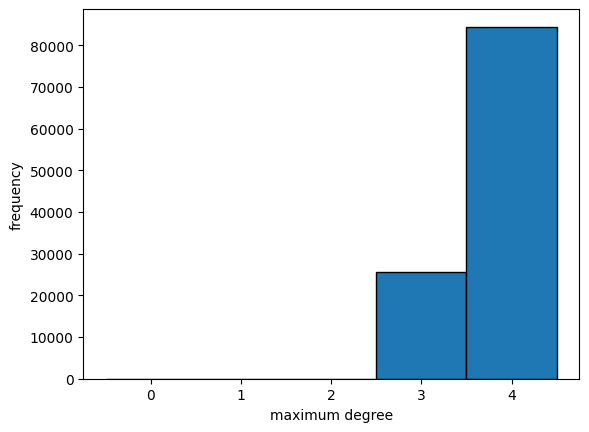

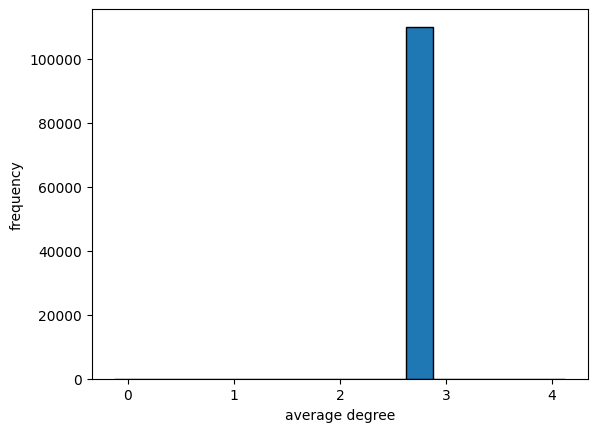

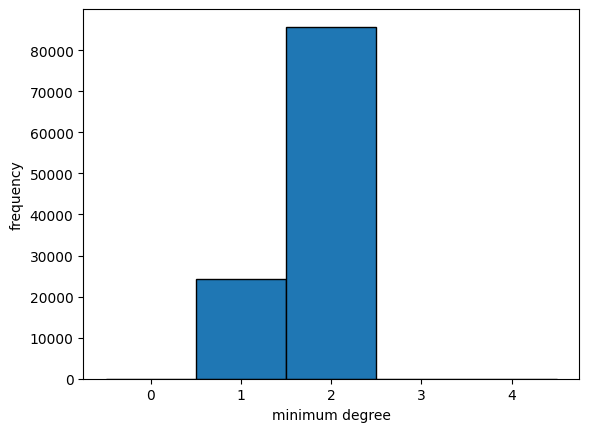

In [4]:
# ----------------- Program -----------------
path += f"rule_{neglection_rule}/"
neglection_thres = float(neglection_thres)

#  check the degree distribution of degrees for a neglection thresold
fname = path + f"neglection_thres_{neglection_thres}_N_5_M_4_K_100_xi_0.npy"
data = np.load(fname, allow_pickle=True).item()

size = data["size"]
print(f"The dataset has a size of {size}")

degree_max = np.zeros(size)
degree_avg = np.zeros(size)
degree_min = np.zeros(size)

for i in range(size):
    degrees = degree_of_nodes(adjacency_from_couplings(data["J_n"][i]))
    #print(degrees)
    degree_max[i] = np.max(degrees)
    degree_min[i] = np.min(degrees)
    degree_avg[i] = np.mean(degrees)

print(f"N = {data['N']}")

bins = get_bin_edges(1, 0, data["N"]-1)
print(bins)
bins_avg = get_bin_edges(avg_binsize, 0, data["N"]-1)


plt.hist(degree_max, align="mid", bins=bins, edgecolor="black")
plt.ylabel("frequency")
plt.xlabel("maximum degree")
plt.show()

plt.hist(degree_avg, align="mid", bins=bins_avg, edgecolor="black")
plt.xlabel("average degree")
plt.ylabel("frequency")
plt.show()

plt.hist(degree_min, align="mid", bins=bins, edgecolor="black")
plt.xlabel("minimum degree")
plt.ylabel("frequency")
plt.show()

The purpose of these diagrams is to verify how many values will be taken into consideration for each degree in order to correctly understand the following diagrams. For instance, for a neglection_thres of 0.08, and neglection rule 1 (threshold method), one can see that the distribution of the maximum degree is approx. centered around 3 meaning that the following evaluation of correct results should yield the highest accuracy for 3 in the max. degree diagram.
Looking at the avg. degree distribution, one notices, that there are certain avg. degrees which don't occur a single time. This is because they are forbidden by the topology of the graph. For instance, if N=5, an average degree of 1 is impossible because if there are two edges in the graph, the avg. degree will be 4/5 and if there are three edges in the graph, the avg. degree will be 6/5 but there will be nothing in between. 

# Evolution of correct results depending on the degree

In [5]:
N_bin_avg_correct, N_bin_avg, N_bin_min_correct, N_bin_min, N_bin_max_correct, N_bin_max, bin_min_max_edges, bin_avg_edges = annealing_by_degree(fname, blocksize, avg_binsize)

In [6]:
def get_ratio_statistics(N_bin_correct, N_bin):
    """Computes the ratio N_bin_correct/N_bin. For the statistics, this function takes into consideration, that N_bin might be zero in some places.
    statistical quantities are computed excluding those places where a np.nan would be in the ratio.
    """
    # ratio of correct identifications
    r_bin_correct = N_bin_correct / N_bin           # there will be np.nan in r_bin_correct since N_bin might be zero at some places
    
    # setup arrays
    N_bins = np.shape(N_bin)[1]
    r_bin_correct_mean = np.zeros(N_bins)
    dr_bin_correct = np.zeros_like(r_bin_correct_mean)
    dr_bin_correct_mean = np.zeros_like(r_bin_correct_mean)

    # compute statistics for every column (i.e. bin) separately to take into account that there might be a different number of values in column due to np.nan in the ratios because of possible zero divisions
    for i in range(N_bins):
        where_not_div_by_0 = np.where(N_bin[:, i]!=0)
        
        if len(where_not_div_by_0[0]) == 0:
            r_bin_correct_mean[i]   = -np.inf               # set to -np.inf to signalize that there were no non-nan values in the column over which the mean would have to be computed -> later one can exclude these datapoints from the plots
            dr_bin_correct[i]       = -np.inf
            dr_bin_correct_mean[i]  = -np.inf
        
        else:
            r_bin_correct_mean[i]   = np.mean(r_bin_correct[:, i][where_not_div_by_0])
            dr_bin_correct[i]       = np.std(r_bin_correct[:, i][where_not_div_by_0])
            dr_bin_correct_mean[i]  = dr_bin_correct[i] / np.sqrt(len(where_not_div_by_0[0]))
    
    return r_bin_correct_mean, dr_bin_correct_mean



r_bin_max_correct_mean, dr_bin_max_correct_mean = get_ratio_statistics(N_bin_max_correct, N_bin_max)
r_bin_min_correct_mean, dr_bin_min_correct_mean = get_ratio_statistics(N_bin_min_correct, N_bin_min)
r_bin_avg_correct_mean, dr_bin_avg_correct_mean = get_ratio_statistics(N_bin_avg_correct, N_bin_avg)

/tmp/ipykernel_4584/3989178443.py:6: RuntimeWarning: invalid value encountered in divide
  r_bin_correct = N_bin_correct / N_bin           # there will be np.nan in r_bin_correct since N_bin might be zero at some places


In [7]:
print(r_bin_max_correct_mean)
print(dr_bin_max_correct_mean)
print(r_bin_min_correct_mean)
print(dr_bin_min_correct_mean)
print(r_bin_avg_correct_mean)
print(dr_bin_avg_correct_mean)

[      -inf       -inf       -inf 0.98793519 0.97639518]
[      -inf       -inf       -inf 0.00067656 0.00050066]
[      -inf 0.97089714 0.98143582       -inf       -inf]
[      -inf 0.00110114 0.00044282       -inf       -inf]
[      -inf       -inf       -inf       -inf       -inf       -inf
       -inf       -inf       -inf       -inf       -inf 0.97915455
       -inf       -inf       -inf       -inf       -inf]
[      -inf       -inf       -inf       -inf       -inf       -inf
       -inf       -inf       -inf       -inf       -inf 0.00041472
       -inf       -inf       -inf       -inf       -inf]


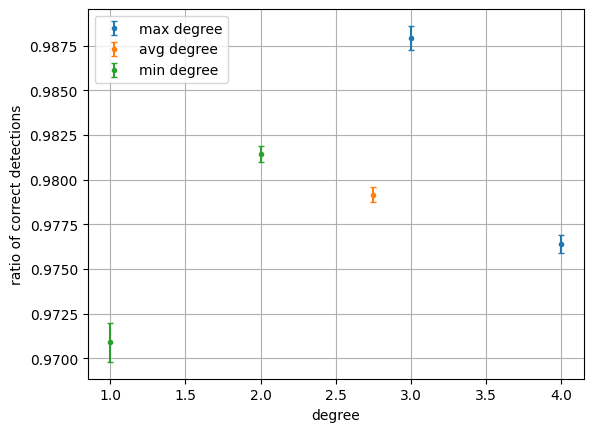

In [8]:
# ------------- plotting --------------
def plot_ratios(bin_edges, r_bin_correct_mean, dr_bin_correct_mean, label):
    x = (bin_edges[1:] + bin_edges[:-1])/2
    where_not_inf = np.where(r_bin_correct_mean != -np.inf)
    plt.errorbar(x=x[where_not_inf], y=r_bin_correct_mean[where_not_inf], yerr=dr_bin_correct_mean[where_not_inf], capsize=2, marker=".", ls="none", label=label)
    

plot_ratios(bin_min_max_edges, r_bin_max_correct_mean, dr_bin_max_correct_mean, "max degree")
plot_ratios(bin_avg_edges, r_bin_avg_correct_mean, dr_bin_avg_correct_mean, "avg degree")
plot_ratios(bin_min_max_edges, r_bin_min_correct_mean, dr_bin_min_correct_mean, "min degree")
plt.xlabel("degree")
plt.ylabel("ratio of correct detections")
plt.grid()
plt.legend()
plt.show()

